# Team2: Pytorch
### Members: 110065508李丞恩 109062676劉廷哲 110062592姜宏昀 110062539古之恒


## Imagenet

## Outline:

- 和Cifar10的架構是類似的

### 1. Model Architecture
- densenet121, max pooling

### 2. Image Preprocessing
- color jitter + random channel shuffle

### 3. Training process

- no, only use reduceLR + early stopping

In [1]:
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 64
EPOCHS = 36
PATIENCE = 9 # 如果過多少個EPOCHS沒改善就停止訓練
CATGORICAL = 2
LR = 1e-3
LR_FACTOR = 0.5 # new_lr = lr * factor.
LR_PATIENCE = 4 # umber of epochs with no improvement after which learning rate will be reduced
MODEL_NAME = 'imagenet_Densenet121_current'
MODEL_PATH = MODEL_NAME + '.hdf5'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import PIL
import time
import random
import string
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from IPython import display
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

from tensorflow import keras
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Input, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        # set memory limit
        #tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 1024)])

       
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Load Data

In [4]:
x_train = np.load('./datalab-cup4-unlearnable-datasets-imagenet/x_train_imagenet_unlearn.npy')
y_train = np.load('./datalab-cup4-unlearnable-datasets-imagenet/y_train_imagenet.npy')
x_val = np.load('./datalab-cup4-unlearnable-datasets-imagenet/x_val_imagenet.npy')
y_val = np.load('./datalab-cup4-unlearnable-datasets-imagenet/y_val_imagenet.npy')
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

In [5]:
# ohe labels
y_train = tf.one_hot(y_train, 2)
y_val = tf.one_hot(y_val, 2)

In [6]:
print(x_train.shape)
print(y_train.shape)

(2220, 224, 224, 3)
(2220, 2)


### define checkpoints

- 這裡我們用ReduceLROnPlateau + early stop，reduce learning rate可以在val acc高時還能進一步改善

In [7]:
checkpoint = ModelCheckpoint(filepath=MODEL_PATH, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             mode='auto', 
                             save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', 
                                   factor=LR_FACTOR, 
                                   patience=LR_PATIENCE, 
                                   verbose=1, 
                                   mode='auto', 
                                   min_delta=1.25e-4)
early = EarlyStopping(monitor='val_acc', 
                      mode="auto", 
                      patience=PATIENCE)

callbacks_list = [checkpoint, reduceLROnPlat, early]
#callbacks_list = [checkpoint, early]

## 1. Model Architecture: Densenet121

以下為preprocessing & data augmentation layer，但效果並不顯著，所以最後沒有使用

In [8]:
# adding Image augmentation layers
# https://keras.io/api/layers/preprocessing_layers/image_augmentation/


rand_image_aug_layer = Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=None),
    tf.keras.layers.RandomContrast(0.1, seed=None)
],
    name='aug_layer'
)

In [9]:
# adding Image batchnormalization layer
# 

batch_norm_layer = Sequential([
#     tf.keras.layers.BatchNormalization(
#     axis=-1,
#     momentum=0.99,
#     epsilon=0.001,
#     center=True,
#     scale=True,
#     beta_initializer="zeros",
#     gamma_initializer="ones",
#     moving_mean_initializer="zeros",
#     moving_variance_initializer="ones",
#     beta_regularizer=None,
#     gamma_regularizer=None,
#     beta_constraint=None,
#     gamma_constraint=None
#     )
    
    tf.keras.layers.LayerNormalization(
    axis=-1,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None
    )
],
    name='batch_norm_layer'
)

In [3]:
# ''' model: imagenet_Densenet121_combined6_acc=96.hdf5 '''
# model = Sequential([
#     # main model
#     tf.keras.applications.DenseNet121(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=INPUT_SHAPE,
#     pooling=max,
#     classes=2
#     ),
# #     layers.Conv2D(2048, (1, 1), activation="relu"),
# #     layers.Dropout(0.25),
# #     layers.Flatten(),
# #     layers.Dropout(0.5),
# #     layers.Dense(10, activation='softmax'),
# ],
#     name=MODEL_NAME
# )
# model.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
# model.summary()

In [2]:
# ''' model: imagenet_densenet121_acc=99.hdf5(打錯) '''
# model = Sequential([
    
#     # random_aug & batch_norm
#     rand_image_aug_layer, #兩個都有
#     batch_norm_layer, #
    
#     # main model
#     tf.keras.applications.DenseNet121(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=INPUT_SHAPE,
#     pooling=max,
#     classes=2
#     ),
# #     layers.Conv2D(2048, (1, 1), activation="relu"),
# #     layers.Dropout(0.25),
# #     layers.Flatten(),
# #     layers.Dropout(0.5),
# #     layers.Dense(10, activation='softmax'),
# ],
#     name=MODEL_NAME
# )
# model.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
# model.summary()

In [12]:
''' try: Densenet121 '''
model = Sequential([
    
    # random_aug & batch_norm
    #rand_image_aug_layer,
    #batch_norm_layer,
    
    # main model
    tf.keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling=max,
    classes=2
    ),
#     layers.Conv2D(2048, (1, 1), activation="relu"),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax'),
],
    name=MODEL_NAME
)
model.build((None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
model.summary()

Model: "imagenet_Densenet121_current"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2)                 7039554   
                                                                 
Total params: 7,039,554
Trainable params: 6,955,906
Non-trainable params: 83,648
_________________________________________________________________


In [13]:
loss_fn = tf.losses.CategoricalCrossentropy(from_logits=False) ##
optimizer = tf.optimizers.Adam(learning_rate=LR)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

## 2. Image Preprocessing

- 我們對原先的image進行各種可能的轉換，以下的cell是從Albumentations的package內的preprocessing function對cifar10 dataset的各種實驗紀錄，分別為training/val acc[epochs]。

- 實驗發現和channels、色調有關，或是pixel-wise的operation的表現很不錯，而單純flip, rotate沒什麼用。

- 最終採用color jitter + channel shuffle的組合，對image進行亮度、色調等的轉換，再random permutate channel的順序

- 由於時間有些緊迫，於是我們在cifar10上試驗出一組較好的combination後，就將相同的方法套用到Imagenet上面。所以兩個dataset的preprocessing是一樣的

In [4]:

''' baseline of x_train: 0.5/0.27[1] ~ 0.94/0.33[4] '''
'''
# cifar10 dataset上面的實驗：

0.（不能用，因為value是float）FancyPCA (alpha=0.1, always_apply=False, p=0.5): X

1. (效果超好！)A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), 
val_shift_limit=(-40./255, -40./255), always_apply=False, p=1)
: 0.41/0.15[1] -> 0.86/0.60[7] -> 0.99/0.66[31]

2. (還行)A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)
: 0.28/0.29[1] -> 0.85/0.38[7] -> 0.95/0.40[10]

3. (bad)A.Downscale (scale_min=0.1, scale_max=0.1, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1)
: 0.47/0.24[1] -> 0.94/0.18[4]

4. (bad)A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1)
: 0.49/0.23 -> 0.95/0.25[4]

5. (還不錯)A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)
: 0.41/0.27[1] -> 0.89/0.46[6]

6. (bad)A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
: 0.49/0.26[1] -> 0.93/0.26[4]

7. (超棒！)A.ChannelShuffle(p=1.0)
: 0.38/0.24[1] -> 0.84/0.59[8] -> 1.0/0.72[50?]
(有把training data存下來了('channelShuffle_data.npy')，因為怕是random channelShuffle剛好有不錯的結果)(QQ被我自己洗掉了)

8.（普通）A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
: 0.44/0.25[1] -> 0.92/0.37[6] -> 0.95/0.32[10]

9. (沒用)HorizontalFlip(p=0.1)
: 0.50/0.27[1] -> 0.92/0.29[3]
實驗證明，flip在這個task根本沒有幫助

10.（普通）A.RGBShift (r_shift_limit=(-40./255, 40./255), g_shift_limit=(-40./255, 40./255), b_shift_limit=(-40./255, 40./255), always_apply=False, p=1.0)
: 0.9/0.37[6]
跟shift的value有關

11. (不錯呦！)A.ToGray(p=1.0)
: 0.39/0.29[1] -> 0.86/0.55[8]

12. (不錯呦！)A.ToSepia (always_apply=False, p=1.0)
: 0.39/0.18[1] -> 0.79/0.52[6] -> 0.96/0.57[11]
train epochs要多點, lr小點，太大會overshoot

13. (bad)A.Superpixels (p_replace=0.1, n_segments=100, max_size=32, interpolation=1, always_apply=False, p=1.0)
: 0.53/0.21[1] -> 0.97/0.29[9]

# combined result:

1. ((1, 7, 7, 11, 12), (5)), with data比例(1: 1: 0.5: 1: 1: 0.5)
: 1.00/0.7374[68]
和7.沒什麼差

2. (1, 7) with (1: 1)
: 0.99/0.70[13]

3. (1.+7.)
: 0.97/0.68[16]

4. (7., 7.) with (1: 1)
: 1.00/0.72[33]

-------------------以上為cifar10的試驗，以下為imagenet的試驗-----------------------------
5. （很棒！）(5.+7.) 
: 0.54/0.53[1] -> 0.94/0.55[9] -> 0.97/0.96[20]
- leraning rate 從5e-4開始，從0.55一直改善到0.96
- 用ReduceLROnPlateau的training strategy可以在acc高的時候，依舊能改善acc而不一直overshoot

'''


In [14]:
import albumentations as A
import cv2
import albumentations.augmentations.transforms as A_trans

In [16]:
''' define types of transformer of images '''

transformer_try = A.Compose([   
    A.HueSaturationValue (hue_shift_limit=(-40./255, 40./255), sat_shift_limit=(-60./255, 60./255), val_shift_limit=(-40./255, 40./255), always_apply=False, p=1),
#    A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)
#    A.Downscale (scale_min=0.1, scale_max=0.9, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1),
#    A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1),
#    A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1),
#    A.Posterize (num_bits=4, always_apply=False, p=1) #不能用
#    A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
#    A.Equalize (mode='cv', by_channels=True, mask=None, mask_params=(), always_apply=False, p=1) #不能用
    A.ChannelShuffle(p=1.0),
#    A.GridDistortion (num_steps=3, interpolation=cv2.INTER_NEAREST, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
#    A.ISONoise (color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=1.0) #不能用
#    A.HorizontalFlip(p=1.0)
#    A.RGBShift (r_shift_limit=(-40./255, 40./255), g_shift_limit=(-40./255, 40./255), b_shift_limit=(-40./255, 40./255), always_apply=False, p=1.0)
#    A.ToGray(p=1.0),
#    A.Sharpen (alpha=(0.3, 0.5), lightness=(0.8, 1.0), always_apply=False, p=1.0)
#    A.ToSepia (always_apply=False, p=1.0)
#    A.GaussianBlur (blur_limit=(11, 15), sigma_limit=0, always_apply=False, p=1)
#    A.PixelDropout(dropout_prob=0.01, per_channel=True, drop_value=None, mask_drop_value=[0, 1], always_apply=False, p=1)
#    A.CoarseDropout (max_holes=8, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=0, mask_fill_value=None, always_apply=False, p=1)
    
    
],  p=1)


transformer1 = A.Compose([   
    A.HueSaturationValue (hue_shift_limit=(-40./255, 40./255), sat_shift_limit=(-60./255, 60./255), val_shift_limit=(-40./255, 40./255), always_apply=False, p=1)
],  p=1)

transformer7 = A.Compose([   
    A.ChannelShuffle(p=1.0)
],  p=1)

transformer11 = A.Compose([   
    A.ToGray(p=1.0)
],  p=1)

transformer12 = A.Compose([   
    A.ToSepia (always_apply=False, p=1.0)
],  p=1)

transformer5 = A.Compose([   
    A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)
],  p=1)

transformer7_11 = A.Compose([   
    A.ChannelShuffle(p=1.0),
    A.ToGray(p=1.0)
],  p=1)

transformer5_7 = A.Compose([
    A.ColorJitter (brightness=0.1, contrast=0.25, saturation=0.25, hue=0.3, always_apply=False, p=1),
    A.ChannelShuffle(p=1.0)
])

transformer1_7 = A.Compose([   
    A.HueSaturationValue (hue_shift_limit=(-40./255, 40./255), sat_shift_limit=(-60./255, 60./255), val_shift_limit=(-40./255, 40./255), always_apply=False, p=1),
    A.ChannelShuffle(p=1.0)
],  p=1)


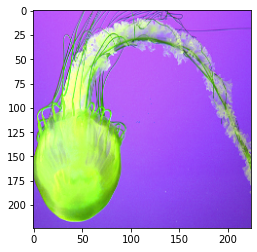

In [17]:
# plot transformer_try
plt.imshow(transformer_try(image = x_train[0])['image'])

In [18]:
def transformed_ds_try(img_ds):
    num = len(img_ds)
    transform_img_ds = []
    
    for i in range(num):
        img_dic = transformer_try(image = img_ds[i])
        transform_img_ds.append(img_dic['image'])
        
    return np.array(transform_img_ds)

### Create transformed training data & Concatenate those data

In [19]:
def transformed_ds(img_ds, transformer):
    num = len(img_ds)
    transform_img_ds = []
    
    for i in range(num):
        img_dic = transformer(image = img_ds[i])
        transform_img_ds.append(img_dic['image'])
        
    return np.array(transform_img_ds)

In [20]:
def create_transformed_data(x_train, y_train, transformer_list, num_data_apply_list):
    x_trans_list = []
    y_trans_list = []
    
    for i in range(len(transformer_list)):
        x_trans_list.append(transformed_ds(x_train, transformer_list[i])[ : num_data_apply_list[i]])
        y_trans_list.append(y_train[ : num_data_apply_list[i]])
        
#     for transformer in transformer_list:
#         x_trans.append(transformed_ds(x_train, transformer))
#         y_trans = np.concatenate((y_train , y_train))
    
    return np.array(np.concatenate(x_trans_list)), np.array(np.concatenate(y_trans_list))

In [21]:
# combined_1
# transformer_list = [transformer1, transformer7, transformer7, transformer11, transformer12, transformer5]
# num_data_apply_list = [len(x_train), len(x_train), len(x_train)//2, len(x_train), len(x_train), len(x_train)//2]

# combined_2
# transformer_list = [transformer1, transformer7]
# num_data_apply_list = [len(x_train), len(x_train)]

# combined_3
# transformer_list = [transformer7_11]
# num_data_apply_list = [len(x_train)]

# combined_4
# transformer_list = [transformer_try]
# num_data_apply_list = [len(x_train)]

# combined_6 
# orignal params(A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1) // val:.98, submit: .94
# new: A.ColorJitter     A.ColorJitter (brightness=0.1, contrast=0.25, saturation=0.25, hue=0.35, always_apply=False, p=1),
transformer_list = [transformer5_7]
num_data_apply_list = [len(x_train)]



# combined_7(bad~)
# transformer_list = [transformer1_7]
# num_data_apply_list = [len(x_train)]

x_train_trans, y_train_trans = create_transformed_data(x_train, y_train, transformer_list, num_data_apply_list)

In [22]:
print(x_train_trans.shape)
print(y_train_trans.shape)

(2220, 224, 224, 3)
(2220, 2)


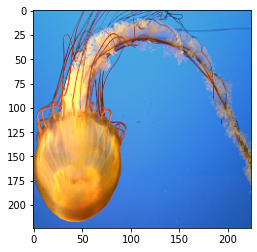

In [23]:
plt.imshow(x_train[0])

### plot one of transformed training data

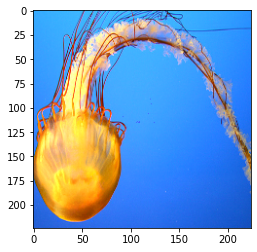

In [24]:
plt.imshow(x_train_trans[0])

In [28]:
# # try

# x_train_trans_try = transformed_ds_try(x_train)
# x_train_trans = x_train_trans_try

In [30]:
# model.load_weights(MODEL_PATH)

In [31]:
#model.load_weights('imagenet_Densenet121_combined6_acc=96.hdf5')

In [33]:
# with open('ChannelShuffle_data.npy', 'wb') as f:
#     np.save(f, x_train_trans)

### Define ta's loss and optimizer

- 這是從ta的code上的optimizer和loss的定義，但training起來的結果差不多

In [34]:
# ''' from ta's code: https://github.com/lionelmessi641BATCH_SIZEntga/blob/main/evaluate.py '''

# lr_schedule = 1e-1
# step_per_epoch = int(len(x_train_trans)/BATCH_SIZE)

# learning_rate_fn = tf.keras.experimental.CosineDecay(lr_schedule, (EPOCHS*step_per_epoch))
# #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9, nesterov=False, name='SGD')
# loss_fn = tf.losses.CategoricalCrossentropy(from_logits=False) ##
# model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

## 3. Start Training

- 這是從前一次train好的model的weight，加上不同color jitter參數生成的input instance下去train的結果。但其實和重新train的結果差不多。代表還是要用不同的image preprocessing的方法才會更有效

In [35]:
#model.load_weights('imagenet_Densenet121_combined6_acc=96.hdf5')

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,  
                                             samplewise_center=False, 
                                             featurewise_std_normalization=False, 
                                             samplewise_std_normalization=False, 
                                             zca_whitening=False, ## val只有0.1
                                             zca_epsilon=1e-06, 
                                             rotation_range=0.0, 
                                             width_shift_range=0.0, ## 0.2
                                             height_shift_range=0.0, ## 0.1
                                             brightness_range=None, ## 不要用，很爛
                                             shear_range=0.0, 
                                             zoom_range=0.0, 
                                             channel_shift_range=0.0, 
                                             fill_mode='nearest', 
                                             cval=0.0, 
                                             horizontal_flip=False, 
                                             vertical_flip=False, ## 不要用，非常糟
                                             rescale=None, 
                                             preprocessing_function=None, 
                                             data_format=None, 
                                             validation_split=0.0, 
                                             dtype=None)

# datagen = ImageDataGenerator(
#     rotation_range=0,
#     width_shift_range=0.0,
#     height_shift_range=0.0)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train_trans, augment=True, rounds=2, seed=None)

# fits the model on batches with real-time data augmentation:
#show_augmented_result_dir = './ImageDataGenerator_result'

history = model.fit(datagen.flow(x_train_trans, y_train_trans, batch_size=BATCH_SIZE, shuffle=True),  shuffle=True,
                              steps_per_epoch=len(x_train_trans)/BATCH_SIZE, epochs=EPOCHS,
                              validation_data=(x_val, y_val),validation_steps=len(x_val)/BATCH_SIZE,
                              callbacks=callbacks_list)

''' baseline of x_train: 0.5/0.27[1] ~ 0.94/0.33[4] '''
'''
0.（不能用，因為value是float）FancyPCA (alpha=0.1, always_apply=False, p=0.5): X

1. (效果超好！)A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), 
val_shift_limit=(-40./255, -40./255), always_apply=False, p=1)
: 0.41/0.15[1] -> 0.86/0.60[7] -> 0.99/0.66[31]

2. (還行)A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)
: 0.28/0.29[1] -> 0.85/0.38[7] -> 0.95/0.40[10]

3. (bad)A.Downscale (scale_min=0.1, scale_max=0.1, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1)
: 0.47/0.24[1] -> 0.94/0.18[4]

4. (bad)A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1)
: 0.49/0.23 -> 0.95/0.25[4]

5. (還不錯)A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)
: 0.41/0.27[1] -> 0.89/0.46[6]

6. (bad)A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)
: 0.49/0.26[1] -> 0.93/0.26[4]

7. (超棒！)A.ChannelShuffle(p=1.0)
: 0.38/0.24[1] -> 0.84/0.59[8] -> 1.0/0.72[50?]
(有把training data存下來了('channelShuffle_data.npy')，因為怕是random channelShuffle剛好有不錯的結果)(QQ被我自己洗掉了)

8.（普通）A.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1)
: 0.44/0.25[1] -> 0.92/0.37[6] -> 0.95/0.32[10]

9. (沒用)HorizontalFlip(p=0.1)
: 0.50/0.27[1] -> 0.92/0.29[3]
實驗證明，flip在這個task根本沒有幫助

10.（普通）A.RGBShift (r_shift_limit=(-40./255, 40./255), g_shift_limit=(-40./255, 40./255), b_shift_limit=(-40./255, 40./255), always_apply=False, p=1.0)
: 0.9/0.37[6]
跟shift的value有關

11. (不錯呦！)A.ToGray(p=1.0)
: 0.39/0.29[1] -> 0.86/0.55[8]

12. (不錯呦！)A.ToSepia (always_apply=False, p=1.0)
: 0.39/0.18[1] -> 0.79/0.52[6] -> 0.96/0.57[11]
train epochs要多點, lr小點，太大會overshoot

13. (bad)A.Superpixels (p_replace=0.1, n_segments=100, max_size=32, interpolation=1, always_apply=False, p=1.0)
: 0.53/0.21[1] -> 0.97/0.29[9]

# combined result:

1. ((1, 7, 7, 11, 12), (5)), with data比例(1: 1: 0.5: 1: 1: 0.5)
: 1.00/0.7374[68]
和7.沒什麼差

2. (1, 7) with (1: 1)
: 0.99/0.70[13]

3. (1.+7.)
: 0.97/0.68[16]

4. (7., 7.) with (1: 1)
: 1.00/0.72[33]

-------------------以上為cifar10的試驗，以下為imagenet的試驗-----------------------------
5. （很棒！）(5.+7.) 
: 0.54/0.53[1] -> 0.94/0.55[9] -> 0.97/0.96[20]
- leraning rate 從5e-4開始，從0.55一直改善到0.96
- 用ReduceLROnPlateau的training strategy可以在acc高的時候，依舊能改善acc而不一直overshoot
'''


Epoch 1/36
35/34 [==============================] - ETA: -2s - loss: 0.2063 - acc: 0.9234
Epoch 00001: val_acc improved from -inf to 0.71316, saving model to imagenet_Densenet121_current.hdf5
34/34 [==============================] - 262s 7s/step - loss: 0.2063 - acc: 0.9234 - val_loss: 1.5818 - val_acc: 0.7132 - lr: 0.0010
Epoch 2/36
35/34 [==============================] - ETA: -2s - loss: 0.1541 - acc: 0.9410
Epoch 00002: val_acc did not improve from 0.71316
34/34 [==============================] - 258s 7s/step - loss: 0.1541 - acc: 0.9410 - val_loss: 109.4514 - val_acc: 0.5132 - lr: 0.0010
Epoch 3/36
35/34 [==============================] - ETA: -2s - loss: 0.1790 - acc: 0.9302
Epoch 00003: val_acc did not improve from 0.71316
34/34 [==============================] - 267s 8s/step - loss: 0.1790 - acc: 0.9302 - val_loss: 82.5268 - val_acc: 0.4395 - lr: 0.0010
Epoch 4/36
35/34 [==============================] - ETA: -2s - loss: 0.1457 - acc: 0.9450
Epoch 00004: val_acc improved from 0

"\n0.（不能用，因為value是float）FancyPCA (alpha=0.1, always_apply=False, p=0.5): X\n\n1. (效果超好！)A.HueSaturationValue (hue_shift_limit=(-40./255, -40./255), sat_shift_limit=(-60./255, -60./255), \nval_shift_limit=(-40./255, -40./255), always_apply=False, p=1)\n: 0.41/0.15[1] -> 0.86/0.60[7] -> 0.99/0.66[31]\n\n2. (還行)A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=1)\n: 0.28/0.29[1] -> 0.85/0.38[7] -> 0.95/0.40[10]\n\n3. (bad)A.Downscale (scale_min=0.1, scale_max=0.1, interpolation=cv2.INTER_NEAREST, always_apply=False, p=1)\n: 0.47/0.24[1] -> 0.94/0.18[4]\n\n4. (bad)A.Emboss (alpha=(0.2, 0.5), strength=(0.2, 0.7), always_apply=False, p=1)\n: 0.49/0.23 -> 0.95/0.25[4]\n\n5. (還不錯)A.ColorJitter (brightness=0.1, contrast=0.2, saturation=0.3, hue=0.2, always_apply=False, p=1)\n: 0.41/0.27[1] -> 0.89/0.46[6]\n\n6. (bad)A.RandomBrightnessContrast (brightness_limit=0.1, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1)\n: 0.49/0.26[1] -> 0.93/0.26[4]

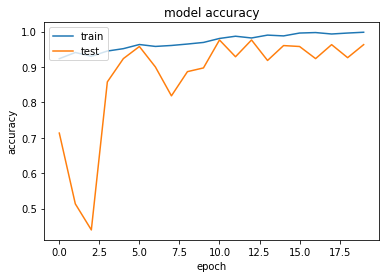

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./output_training_plot/densenet121_try5_current', dpi='figure')
plt.show()

## Testing data output

In [38]:
model.load_weights(MODEL_PATH)

In [39]:
x_test = np.load('./datalab-cup4-unlearnable-datasets-imagenet/x_test_imagenet.npy')

In [40]:
y_test = np.argmax(model.predict(x_test, batch_size=BATCH_SIZE, verbose=1), axis=1).tolist()

2/2 [==============================] - 3s 566ms/step


In [41]:
id_csv = [i for i in range(len(y_test))]
df = pd.DataFrame(list(zip(id_csv,y_test)), columns = ['id','label'])
df.to_csv('./output_csv/imagenet_densenet121_current.csv', index=False)

## Reference:

## image preprocessing

### Albumentations package preprocessing function
https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.FancyPCA

https://hackmd.io/@allen108108/SyCsOIkxB

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://keras.io/zh/preprocessing/image/

http://www.tisv.cn/14/

### ImageDataGenerator:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

#### 